## topics outline

# why are 2 interacting RR robots different than a 5barlinkage?
# what does the most general 5 bar linkage look like? 
 - go through derivation written up
 - gen5barlinkage class definition
 - gen5barlinkage exploration tool
# what does the human model look like?
- derivation (picture and talking about it)
- human class definition
- human model exploration tool. 
# put the two together
- joint exploration tool 

#end of goal for this week. next week, finish up loose ends (there are likely to be many) , and solve the constrained optimization problem. 
# Solve the constrained optimization problem. 



#neal notes:

speed up code with cython
https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/?fbclid=IwAR1_KPRJACFUJk6-TYb1DqumE9Cn3hk40QUOl10UCyItL2z4Ft5x_s-Nc60
numba, JIT

python optimization with pyomo http://egon.cheme.cmu.edu/ewo/docs/EWO_Seminar_03_10_2017.pdf


In [79]:
# utility functions:

class utils:
    """
    utility functions shared between different classes
    """
    @staticmethod
    def dist(x1,y1,x2,y2):
        """
        calculate the distance between 2 points
        """
        return ((x2 - x1)**2 + (y2 - y1)**2)**.5
    
    @staticmethod
    def GD(x0,df,params):
        """
        peform gradient decent, given df, a function for calculating the 
        derivate of the function to be optimized. 
        """
        next_x = x0   # We start at x0
        gamma = 0.01  # Step size multiplier
        precision = 0.0001  # Desired precision of result
        max_iters = 10000  # Maximum number of iterations
        
        for _ in range(max_iters):
            current_x = next_x
            next_x = current_x - gamma * df(current_x,params)

            step = next_x - current_x
            if abs(step) <= precision:
                break

        return next_x


# what does the most general 5 bar linkage look like? 



In [ ]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon

class gen5barlinkage:

# what does the human model look like?

In [89]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

    
##design decision - should I treat Human more functionally - so basically as a static class, but without state, and more of a container for functions, or should I rely heavily 
#on state caching, which means I have to guarentee order of function calls inorder for things to be up to date. this is the fundemental tradeoff of functional vs stateful approaches. 
# other design decisions, would sampling happen in cartesian, or in joint space for the optimization? - at least some of that sampling should live in another class that handles the
#optimization between the human aand the 

class JointSpring:
    def __init__(self,θo,K,θmin,θmax):
        self.θo = θo;
        self.K = K;
        self.θmin = θmin
        self.θmax = θmax
        
    def PE(self,θ,mode = "linear"):
        """
        calculates and return the potential energy of the 
        spring given the angular displacement θ and the 
        """
        if mode == "linear":
            return .5 * self.K * (θ - self.θo)**2
        elif mode == "quadratic":
            return (1/3) * self.K *(θ - self.θo)**3
        elif mode == "softLimits":
            pass
        else:
            raise ValueError("mode {} not yet implemented".format(mode))


class Human:
    def __init__(self):
        #segment lengths
        self.femur = 1 
        self.shank = 1
        self.foot = 1
        
        #joint limits
        self.θh_max = np.pi/180 *  90
        self.θh_min = np.pi/180 * -45
        self.θk_max = np.pi/180 *  0
        self.θk_min = np.pi/180 * -120
        self.θa_max = np.pi/180 * 90
        self.θa_min = np.pi/180 * 10
        
        #IK joint springs
        self.θhSpring = JointSpring(0,.5,self.θh_min,self.θh_max)
        self.θkSpring = JointSpring(0,.5,self.θk_min,self.θk_max)
        self.θaSpring = JointSpring(0,.5,self.θa_min,self.θa_max)
        

        
    #------------- private functions --------------------    
    def _IK_analytical(self,x_e,y_e,ϕ):
        """
        given a midfoot location and an orientation, return the joint angles
        by solving the analytical IK with wrist - end effector separation
        based on lect5 kinematics - slides 9-10
        """
        #define link lengths
        l1=self.femur
        l2=self.shank
        l3=self.foot/2
        
        #solve first for the wrist location
        x_w = x_e - l3*np.cos(ϕ)
        y_w = y_e - l3*np.sin(ϕ)
        
        #solve for intermediate values
        r = utils.dist(0,0,x_w,y_w)
        β = np.arccos((l1**2 + l2**2 - r**2) / (2*l1*l2))
        γ = np.arccos((r**2 + l1**2 - l2**2) / (2*r*l1))
        α = np.arctan2(y_w,x_w)
        
        #calculate θ's 
        θ1 = α - γ
        θ2 = np.pi - β
        θ3 = ϕ - θ1 - θ2
        
        #calc θ_primes for elbow up config
        θ1pm = θ1 + 2*γ  
        θ2pm = -θ2                      
        θ3pm = θ3 + 2*(θ2 - γ)
        
        return θ1pm,θ2pm,θ3pm
    
    
    def _IK_energy_fxn(self,θh,θk,θa):
        """
        defines the potential energy landscape
        """
        pe_h = self.θhSpring.PE(θh,mode = "linear")
        pe_k = self.θaSpring.PE(θk,mode = "linear")
        pe_a = self.θkSpring.PE(θa,mode = "linear")
        
        return pe_h + pe_k + pe_a
    
    def _energy_grad(self,ϕ,params):
        """
        calculate the gradient of the energy function using 
        finite differences for use in gradient decent
        """
        x = params[0] ; y = params[1]
        δ = .0001
        δm_θh,δm_θhk,δm_θa = self._IK_analytical(x,y,ϕ - δ)
        δp_θh,δp_θhk,δp_θa = self._IK_analytical(x,y,ϕ + δ)
        
        δmPE = self._IK_energy_fxn(δm_θh,δm_θhk,δm_θa)
        δpPE = self._IK_energy_fxn(δp_θh,δp_θhk,δp_θa)
        
        return -(δpPE - δmPE) / 2*δ
    
    def _IK_scipy_obj_fxn(self,ϕ,x,y):
        """defines an objective function for scipy.optimize.minimize"""
        θh,θk,θa = self._IK_analytical(x,y,ϕ)
        return self._IK_energy_fxn(θh,θk,θa)   
    
    def IK(self,x,y,method = "analytical"):
        """
        given a location x,y of the midfoot, what are the joint angles required to
        achieve that position? 
        """
        #check that IK can be performed
        #don't consider reaching just the foot
        if utils.dist(0,0,x,y) > self.femur + self.shank:
            return np.nan
        
        #method == analytical -> 3ms per evaluation...can we do better? 
        #determine ϕ of least potential energy
        if method == "analytical":
            ϕ_guess = self.θhSpring.θo + self.θkSpring.θo + self.θaSpring.θo
            res = minimize(self._IK_scipy_obj_fxn,(ϕ_guess),(x,y), method = 'nelder-mead')
            ϕ_min = res.x[0]
            θh,θk,θa = self._IK_analytical(x,y,ϕ_min)
            return θh,θk,θa
#             ϕ_min = utils.GD(ϕ_guess,self._energy_grad,(x,y))
#             θh,θk,θa = self._IK_analytical(x,y,ϕ_min)
#             return θh,θk,θa
        
        else:
            raise ValueError("method {} not yet implemented".format(method))

        #look into faster ways of optimizing this in the future - including a joint optimizatio
        #idea - define an energy function with springs, and an analytical 
            
        #method == numerical
            #idea - do the same thing as above, but solve the IK, then the energy function back
            #and forth
        #method == attractor use an attractor method with joint springs, like the one I used for 739 final project
        #which is solving the energy function at the same time as the 
        #method == optimization w/ bounds 
            #idea: solve with an explicit optimizer (cvxpy) - setup joint limits as constraints, 

        #return θh,θk,θa
    
    def _FK(self,θh,θk,θa):
        """
        calculate the forward kinematics of each joint and the contact point
        returns: 
            vectors of x and y coordinates of forward kinematic
            [hip,knee,ankle,midfoot,toe]
        """
        #calculate the sines and cosines of successive angles
        s_h   = np.sin(θh)        ; c_h   = np.cos(θh)
        s_hk  = np.sin(θh+θk)     ; c_hk  = np.cos(θh+θk)
        s_hka = np.sin(θh+θk+θa)  ; c_hka = np.cos(θh+θk+θa)
        
        #perform the forward kinematics 
        hip     = [0,0]
        knee    = [  hip[0] + self.femur*c_h ,      hip[1] + self.femur*s_h]                                     
        ankle   = [ knee[0] + self.shank*c_hk ,    knee[1] + self.shank*s_hk]
        midfoot = [ankle[0] +(self.foot/2)*c_hka, ankle[1] +(self.foot/2)*s_hka]
        toe     = [ankle[0] + self.foot*c_hka,    ankle[1] + self.foot*s_hka]
        
        #reorganize into vectors
        x = [hip[0],knee[0],ankle[0],midfoot[0],toe[0]]
        y = [hip[1],knee[1],ankle[1],midfoot[1],toe[1]]
        
        return (x,y)
 
    
    #torque calculation functions (from tables)
    def _τh(self,θh,θk):
        pass
        #develop some sort of spline interpolation fxn in n variables.
    
    def _τk(self,θh,θk,θa):
        pass
    
    def _τa(self,θk,θa):
        pass
    
    def _τspace(self):
        pass
        #τh = self.τh(θh,θk) ; τk = self.τh(θh,θk,θa) ; τa = self.τa(θk,θa)
    
    def _Jac(self,θh,θk,θa):
        pass
    
    def bounds(self,method = "full sample"):
        """
        return the bounds in the x,y plane over which the human leg can reach, given
        the set of joint limits
        """
        if method == "full sample" or method == "boundry sample":
            #calculate the set of points using sampling methods
            nh = 50; nk = 25; 
            pts = np.zeros((nh*nk + 1,2)); i = 0 #flat list
#             for θh in np.linspace(self.θh_min,self.θh_max,nh):
#                 for θk in np.linspace(self.θk_min,self.θk_max,nk):
#                     x,y = self._FK(θh,θk,np.pi/4)
#                     pts[i,:] = np.array((x[2],y[2]))

            for θk in np.linspace(self.θk_min,self.θk_max,nh):
                for θh in np.linspace(self.θh_min,self.θh_max,nk):
                    x,y = self._FK(θh,θk,np.pi/4)
                    pts[i,:] = np.array((x[2],y[2]))
#                     for θa in np.linspace(self.θa_min,self.θa_max,na):
#                         pts[i,:] = np.array(self.FK(θh,θk,θa))
                    i += 1
            if method == "full sample":
                return pts[:,0] , pts[:,1]
            
            #the workspace we want isn't convex and this proves it.
            if method == "boundry sample": 
                hull = ConvexHull(pts)
                hullPts = pts[hull.vertices,:]
                return hullPts[:,0] , hullPts[:,1]
    
    # ---------------------- public facing functions ------------------------------
    def FK(self,θh,θk,θa):
        """
        given the joint angles θh,θk,θa, where is the middle of the foot located in space?
        """
        x,y = self._FK(θh,θk,θa) ; return (x[3],y[3])
    
    def FKplot(self,θh,θk,θa):
        """
        forward kinematic plotting vector for viewing human leg
        """
        return self._FK(θh,θk,θa)
        
    def FS(self,x,y):
        """
        evaluate the Force Space of the human at a particular location location in the saggital plane
        and return a shape object that can be used to score FS overlap
        """
        self.IK(x,y)  #update internal state
        jac = self.Jac()
        τs = self.τspace()
        
        #jac * τs -> force space
        return fs
    
    def FSplot(self,x,y):
        """
        return the points required to plot the force space
        """
        pass
    
    def IKplot(self,x,y):
        """return the points for plotting human leg"""
        pass
        
        
         
    

#----------------------------------- tests ----------------------------------
def test_human():
    h = Human()
    def test_FS():
        pass
    pass

test = False
if test:
    test_human()
    
        
#---------------------------------- plotting ---------------------------------
h = Human()

fig = go.FigureWidget()

# fig.update_xaxes(range=[-6, 6])
# fig.update_yaxes(range=[-6, 6])

#configure layout of graph
side = 1000
fig.update_layout(
    autosize=False,
    width=side + 100,
    height=side,
    legend=dict(x=.025, y=.975),
    margin=dict(l=80, r=80, t=0, b=80))

#make plot with original circle, and model robot in it.
xs,ys = h.bounds()
fig.add_scatter(x=xs,y=ys,mode="markers", marker = dict(color = np.linspace(0,1,50*25)))
#fig.add_scatter(x=xs,y=ys, marker = dict(color = np.linspace(0,1,50*25)))
#fig.add_scatter(line=dict(color='royalblue', width=2)      ,name="leg")

FigureWidget({
    'data': [{'marker': {'color': array([0.00000000e+00, 8.00640512e-04, 1.60128102e-03, ..., 9…

In [90]:
#%timeit h._IK_analytical(1.5,1.25,0)

h.IK(1.5,1.25)

(1.538905327846682, -1.2856998865634202, -0.25320544125060374)

In [84]:
#%timeit h._IK_analytical(1.5,1.25,0)

h.IK(1.5,1.25)

(1.3362223351373426, -0.7661867696674873, -1.1222230654698557)

to do: what are my goals for this visualizer?
* be able to debug the human class
* visualize the bounds and bounds check function
* visualize the process of IK, and how it's being solved
* visualize the force space of the human


the calculated space depends on whether the robot's are elbow in or elbow out.
$det(A^{-1}) = \frac{1}{det(A)}$

in words, how do you want this to work? 
* when visualize forceSpaces is selected, you have free control over the movement of \theta1 and \theta2, and can see the calculated force spaces. FR scales the robot force space. when you select that button, the blue robot becomes bold, and is the leader, the robot follows through IK. if the human leaves the area, then robot should disappear, until we are back in the interaction area. 
* the feature is separate from and is drawn over top of the mode controur map. 
    
* what am I trying to do right now? 
- build the visualization tool that will help explain why the inscribed and actuator effort modes have such asymmetries 

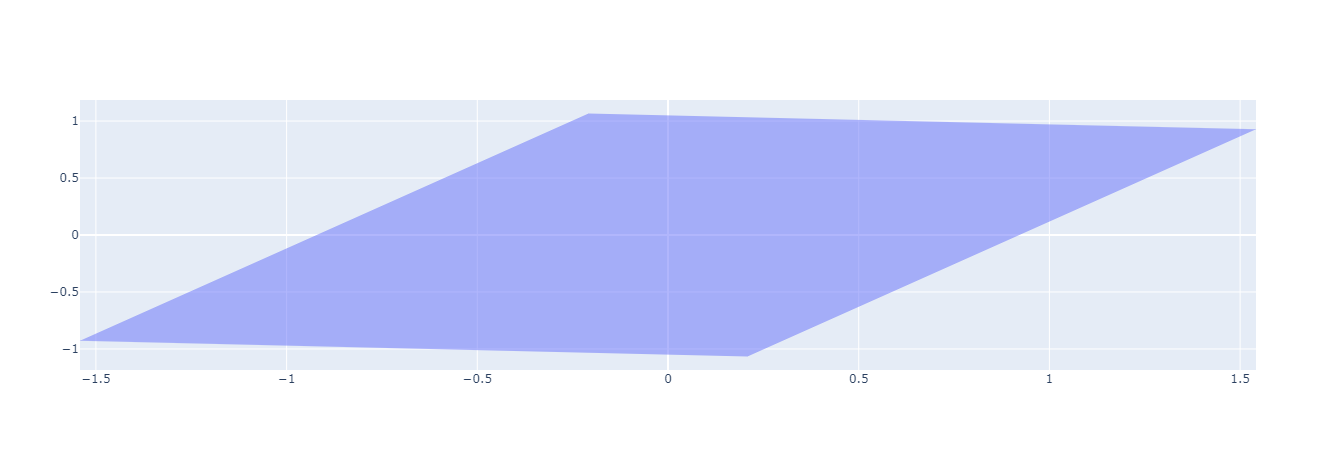

In [14]:
import plotly.graph_objects as go


x = np.array([-0.20833333, -1.54166667,  0.20833333,  1.54166667,-0.20833333])
y = np.array([ 1.0662811 , -0.92900195, -1.0662811 ,  0.92900195, 1.0662811 ])




fig = go.Figure()
#fig.add_trace(go.Scatter(x=x, y=y, fill='tozeroy',fillcolor='royalblue',mode='none'))
#fig.add_trace(go.Scatter(x=x, y=y, fill='tonexty',fillcolor='red',mode= 'none'))
fig.add_trace(go.Scatter(x=x, y=y, fill='tozeroy',mode='none'))
fig.show()